In [1]:
!pip install ultralytics

In [2]:
import ultralytics
ultralytics.__version__

'8.2.11'

In [3]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
from tracker import Tracker
import os
import time
model=YOLO('yolov8s.pt')

In [4]:
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
              'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [5]:
tracker=Tracker()
count=0

In [6]:
cap=cv2.VideoCapture('highway_mini.mp4')

In [7]:
down = {}
up = {}
counter_down = []
counter_up = []
down_speed =[]
up_speed =[]
red_line_y = 198
blue_line_y = 268
offset = 6
up_fined = []
down_fined = []
traffic_up = []
traffic_down = []
start_time = time.time()
interval = 30  # Time interval for counting (in seconds)
timer_up = 0
timer_down = 0
# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' or 'truck' in c:
            list.append([x1, y1, x2, y2])
        
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2
        
        if red_line_y<(cy+offset) and red_line_y > (cy-offset):
           down[id]=time.time()   # current time when vehichle touch the first line
        if id in down:
          
           if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
             elapsed_time=time.time() - down[id]  # current time when vehicle touch the second line. Also we a re minusing the previous time ( current time of line 1)
             if counter_down.count(id)==0:
                counter_down.append(id)
                distance = 10 # meters 
                a_speed_ms = distance / elapsed_time
                a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside
                down_speed.append(a_speed_kh)
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh)*(544.5/42))+'Km/h',(x4,y4 ),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
                a_speed_kh = a_speed_kh*(544.9/42)
                if(a_speed_kh>55):
                    cv2.putText(frame,'fined',(x4+10,y4+10),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)   

                
        #####going UP blue line#####     
        if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
           up[id]=time.time()
        if id in up:

           if red_line_y<(cy+offset) and red_line_y > (cy-offset):
             elapsed1_time=time.time() - up[id] 
             if counter_up.count(id)==0:
                counter_up.append(id)      
                distance1 = 10 # meters  (Distance between the 2 lines is 10 meters )
                a_speed_ms1 = distance1 / elapsed1_time
                a_speed_kh1 = a_speed_ms1 * 3.6
                up_speed.append(a_speed_kh1)
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh1)*(544.5/42))+'Km/h',(x4,y4),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
                a_speed_kh1 = a_speed_kh1*(195/9)
                if(a_speed_kh1>55):
                    cv2.putText(frame,'fined',(x4+20,y4+20),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)   
                # if(time.time()==3):
                #     traffic_up.append(len(counter_up))
                # if(time.time()%3==0 and time.time()!=3):
                #     traffic_up.append(len(counter_up)-traffic_up[-1])
    current_time = time.time()
    if current_time - start_time >= interval:
        traffic_up.append(len(counter_up) - timer_up)
        traffic_down.append(len(counter_down) - timer_down)
        start_time = current_time
        timer_up = len(counter_up)
        timer_down = len(counter_down)
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
    #if cv2.waitKey(0) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 320x640 9 cars, 3 trucks, 680.3ms
Speed: 20.2ms preprocess, 680.3ms inference, 4145.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 309.3ms
Speed: 2.9ms preprocess, 309.3ms inference, 4.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 402.6ms
Speed: 5.0ms preprocess, 402.6ms inference, 5.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 506.7ms
Speed: 4.4ms preprocess, 506.7ms inference, 7.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 879.4ms
Speed: 9.3ms preprocess, 879.4ms inference, 9.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 702.1ms
Speed: 7.8ms preprocess, 702.1ms inference, 6.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 600.2ms
Speed: 6.0ms preprocess, 600.2ms inference, 5.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 585.8ms
Speed:

In [8]:
cap1=cv2.VideoCapture('highway.mp4')

In [9]:
import os
import cv2
import pandas as pd
import time

# Define the paths and other variables
# Make sure to define 'cap', 'model', 'tracker', and 'class_list' before using this code

down1 = {}
up1 = {}
counter_down1 = []
counter_up1 = []
down_speed1 = []
up_speed1 = []
red_line_y = 198
blue_line_y = 268
offset1 = 6
up_fined1 = []
down_fined1 = []
traffic_up1 = []
traffic_down1 = []
start_time1 = time.time()
interval1 = 30  # Time interval for counting (in seconds)
timer_up1 = 0
timer_down1 = 0

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap1.read()
    if not ret:
        break
    count += 1
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c or 'truck' in c:  # Modified condition
            list.append([x1, y1, x2, y2])
        
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2
        
        if red_line_y < (cy + offset1) and red_line_y > (cy - offset1):
            down1[id] = time.time()  # current time when vehicle touches the first line
        
        if id in down1:
            if blue_line_y < (cy + offset1) and blue_line_y > (cy - offset1):
                elapsed_time = time.time() - down1[id]  # current time when vehicle touches the second line
                if counter_down1.count(id) == 0:
                    counter_down1.append(id)
                    distance = 10  # meters 
                    a_speed_ms = distance / elapsed_time
                    a_speed_kh = a_speed_ms * 3.6  # kilometers per hour for each vehicle
                    down_speed1.append(a_speed_kh)
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh )) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
                    
                    if a_speed_kh > 55:
                        cv2.putText(frame, 'fined', (x4 + 10, y4 + 10), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)   

        if blue_line_y < (cy + offset1) and blue_line_y > (cy - offset1):
            up1[id] = time.time()
        
        if id in up1:
            if red_line_y < (cy + offset1) and red_line_y > (cy - offset1):
                elapsed1_time = time.time() - up1[id]
                if counter_up1.count(id) == 0:
                    counter_up1.append(id)      
                    distance1 = 10  # meters  (Distance between the 2 lines is 10 meters )
                    a_speed_ms1 = distance1 / elapsed1_time
                    a_speed_kh1 = a_speed_ms1 * 3.6
                    up_speed1.append(a_speed_kh1)
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh1 )) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
                    
                    if a_speed_kh1 > 30:
                        cv2.putText(frame, 'fined', (x4 + 20, y4 + 20), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)   

    current_time = time.time()
    if current_time - start_time1 >= interval1:
        traffic_up1.append(len(counter_up1) - timer_up1)
        traffic_down1.append(len(counter_down1) - timer_down1)
        start_time1 = current_time
        timer_up1 = len(counter_up1)
        timer_down1 = len(counter_down1)
    
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines
    
    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down1))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up1))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)

    if time.time() >= start_time1 + 30:
        break
    
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 320x640 8 cars, 2 trucks, 286.8ms
Speed: 5.0ms preprocess, 286.8ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 296.0ms
Speed: 2.9ms preprocess, 296.0ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 310.2ms
Speed: 3.8ms preprocess, 310.2ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 288.0ms
Speed: 3.3ms preprocess, 288.0ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 278.1ms
Speed: 5.0ms preprocess, 278.1ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 283.7ms
Speed: 3.0ms preprocess, 283.7ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 272.1ms
Speed: 3.0ms preprocess, 272.1ms inference, 3.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 298.7ms
Speed: 4.0m

In [10]:
for i in range(len(up_speed)):
    up_speed[i] = up_speed[i]*(726.5/42)
print(up_speed)

[44.42443980092805, 42.75243520376277, 38.03422777185769]


In [11]:
for i in range(len(down_speed)):
    down_speed[i] = down_speed[i]*(726.5/42)
print(down_speed)

[42.551377194149474, 54.244356528605515, 63.89137491600811, 64.7584563181881, 45.804789928913024, 46.721658328478526, 65.04308349229123, 43.222941092943834]


In [12]:
for i in range(len(up_speed1)):
    up_speed1[i] = up_speed1[i]*(726.5/42)
print(up_speed1)

[35.28351779593793, 34.15314989630067, 39.225597173167685, 37.729475609050354, 30.832674003027712, 47.72968208668683, 39.44742137508388, 37.01715556030555, 48.28567731144586, 36.96729800082527, 30.97122242062963, 46.192420890339186, 38.410296871663675, 45.027018152349754, 36.31408657819052, 45.29376138927896, 32.15399284984677, 43.647655685319656, 39.706117143446434, 32.515967451385166, 46.59575767116589, 52.02375881552706, 44.96980034675822, 63.59569240647277, 33.757527944308976, 39.914671009468904, 57.240799194651395, 44.348003756829804, 44.209601244678154, 52.65912113812868, 39.97851721695613, 41.76987679029772, 42.25476578603725]


In [13]:
for i in range(len(down_speed1)):
    down_speed1[i] = down_speed1[i]*(726/42)
print(down_speed1)

[34.17657675421273, 41.71664836535074, 45.60491786993405, 56.55253006464551, 45.688969071700896, 37.69341398375189, 45.6188126967257, 46.27941303297087, 41.42700493152505, 41.86825364890806, 38.01278371256195, 48.655938289538675, 62.25232771226861, 41.29884579412122, 58.51068367970463, 57.1479538187658, 56.58380438504388, 57.42133313775504, 60.435329830414624, 45.409714897099484, 52.323139329899334, 47.029849041021905, 49.94632244184924, 46.682605317859014, 40.03506844963778, 57.62527491907748, 54.24716358461191, 67.57913809978359, 57.63265243394364, 41.746256808996556, 44.90746815924153, 61.61039252637508, 47.08651710330747]


In [14]:
print(traffic_up1)
    

[0, 2, 1, 4, 3, 3, 1, 5, 1, 2, 2, 0, 1, 0, 3, 1, 1, 1, 1, 1]


In [15]:
print(traffic_down1)

[0, 2, 1, 3, 1, 1, 0, 2, 3, 3, 2, 3, 1, 1, 2, 0, 3, 2, 2, 1]


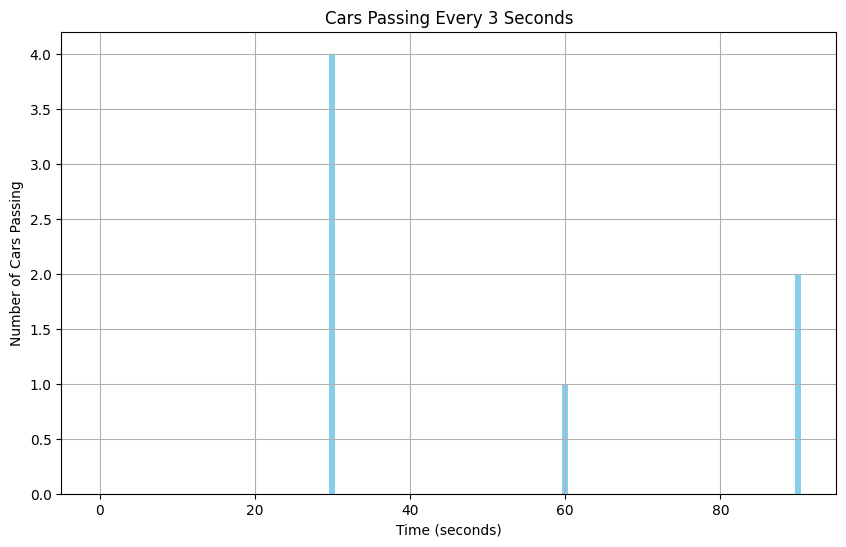

In [16]:
import matplotlib.pyplot as plt

# Data for visualization
# passing_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

# Define time intervals
time_intervals = [i * interval for i in range(len(traffic_down))]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(time_intervals, traffic_down, color='skyblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Cars Passing')
plt.title('Cars Passing Every 3 Seconds')
plt.grid(True)
plt.show()


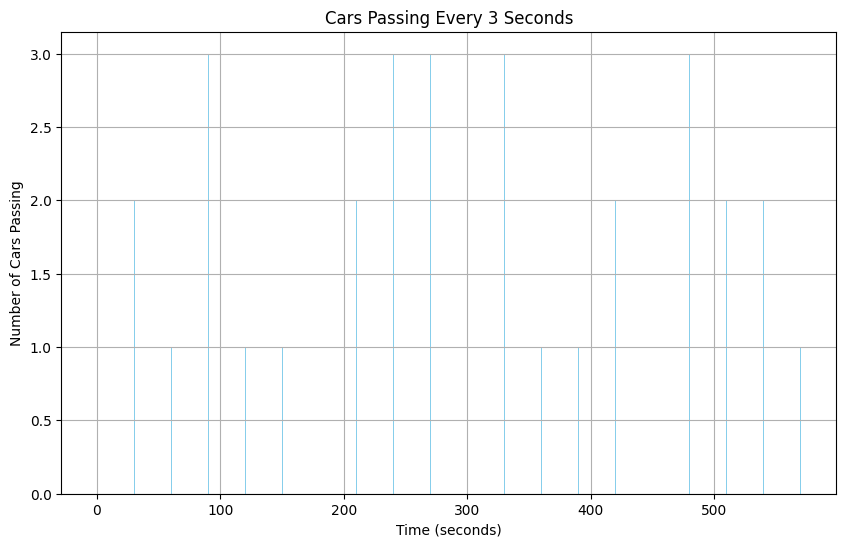

In [17]:
import matplotlib.pyplot as plt

# Data for visualization
# passing_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

# Define time intervals
time_intervals = [i * interval for i in range(len(traffic_down1))]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(time_intervals, traffic_down1, color='skyblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Cars Passing')
plt.title('Cars Passing Every 3 Seconds')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

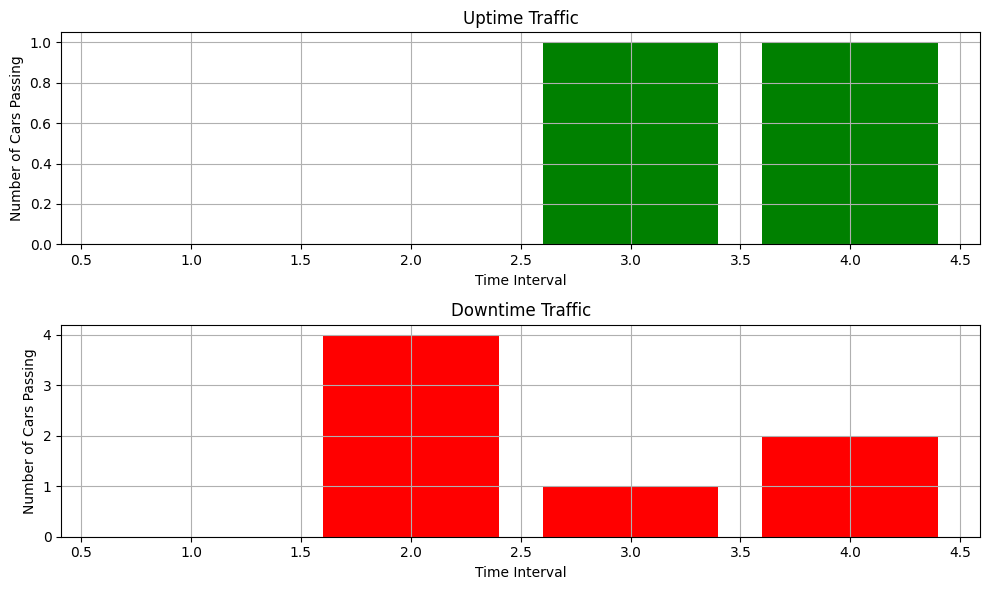

In [18]:
import matplotlib.pyplot as plt

# Sample data for uptime and downtime
# uptime_traffic = [5, 8, 10, 7, 6]  # Sample data for cars passing during uptime
# downtime_traffic = [3, 4, 6, 5, 4]  # Sample data for cars passing during downtime

# Time intervals
# time_intervals = ['Time 1', 'Time 2', 'Time 3', 'Time 4', 'Time 5']

# Create bar plots for uptime and downtime traffic
plt.figure(figsize=(10, 6))
import matplotlib.pyplot as plt

# Sample data for uptime and downtime
uptime_traffic = traffic_up
downtime_traffic = traffic_down

# Time intervals
time_intervals = [i for i in range(1, len(uptime_traffic) + 1)]

# Create bar plots for uptime and downtime traffic
plt.figure(figsize=(10, 6))

# Plot for uptime traffic
plt.subplot(2, 1, 1)
plt.bar(time_intervals, uptime_traffic, color='green')
plt.xlabel('Time Interval')
plt.ylabel('Number of Cars Passing')
plt.title('Uptime Traffic')
plt.grid(True)

# Plot for downtime traffic
plt.subplot(2, 1, 2)
plt.bar(time_intervals, downtime_traffic, color='red')
plt.xlabel('Time Interval')
plt.ylabel('Number of Cars Passing')
plt.title('Downtime Traffic')
plt.grid(True)

plt.tight_layout()
plt.show()



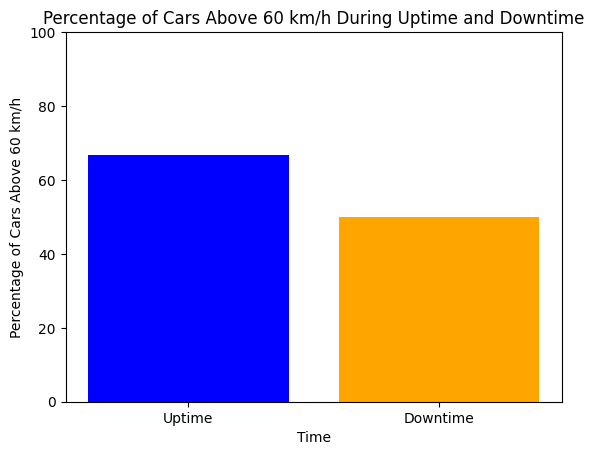

In [22]:
import matplotlib.pyplot as plt

# Function to calculate percentage
def calculate_percentage(count, total):
    return (count / total) * 100 if total > 0 else 0

# Counting cars above 60 km/h during uptime
uptime_above_60 = sum(speed > 40 for speed in up_speed)

# Counting cars above 60 km/h during downtime
downtime_above_60 = sum(speed > 50 for speed in down_speed)

# Total number of cars during uptime and downtime
total_cars_uptime = len(up_speed)
total_cars_downtime = len(down_speed)

# Calculate percentages
percentage_above_60_uptime = calculate_percentage(uptime_above_60, total_cars_uptime)
percentage_above_60_downtime = calculate_percentage(downtime_above_60, total_cars_downtime)

# Plotting
labels = ['Uptime', 'Downtime']
percentages = [percentage_above_60_uptime, percentage_above_60_downtime]

plt.bar(labels, percentages, color=['blue', 'orange'])
plt.xlabel('Time')
plt.ylabel('Percentage of Cars Above 60 km/h')
plt.title('Percentage of Cars Above 60 km/h During Uptime and Downtime')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.show()


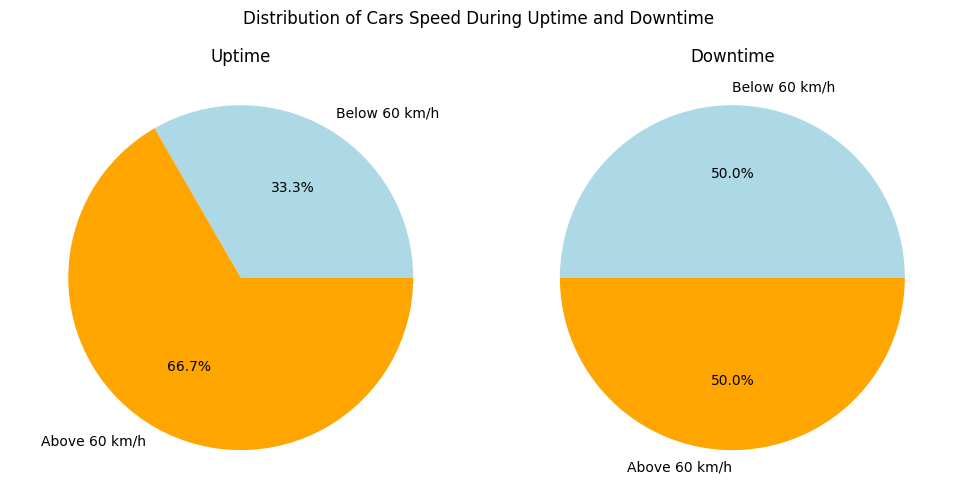

In [23]:
import matplotlib.pyplot as plt

# Counting cars below and above 60 km/h during uptime
uptime_below_60 = total_cars_uptime - uptime_above_60
# Counting cars below and above 60 km/h during downtime
downtime_below_60 = total_cars_downtime - downtime_above_60

# Data for the pie chart
labels = ['Below 60 km/h', 'Above 60 km/h']
sizes_uptime = [uptime_below_60, uptime_above_60]
sizes_downtime = [downtime_below_60, downtime_above_60]

# Plotting uptime pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(sizes_uptime, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'orange'])
plt.title('Uptime')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Plotting downtime pie chart
plt.subplot(1, 2, 2)
plt.pie(sizes_downtime, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'orange'])
plt.title('Downtime')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.suptitle('Distribution of Cars Speed During Uptime and Downtime')
plt.tight_layout()
plt.show()


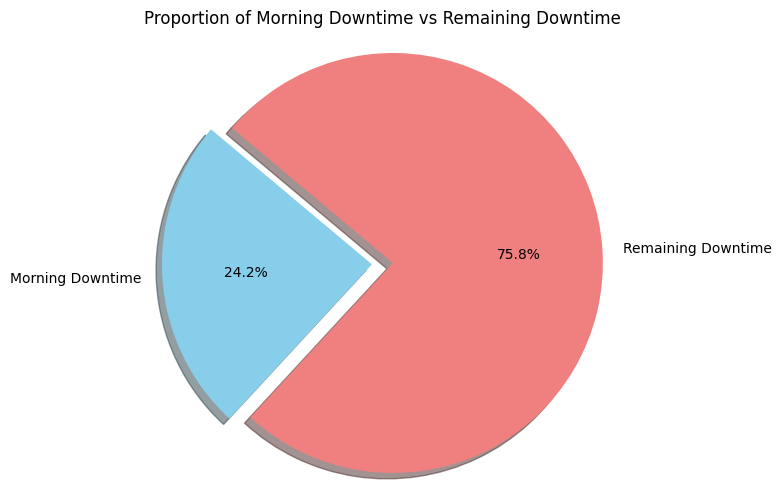

In [24]:
import matplotlib.pyplot as plt

# Sample data for downtime and downtime1
  # Morning downtime in minutes
   # Total downtime for the day in minutes

# Calculating the proportion of morning downtime
morning_proportion = total_cars_downtime/ len(down_speed1)

# Calculating the proportion of total downtime excluding morning downtime
remaining_proportion = 1 - morning_proportion

# Pie chart data
labels = ['Morning Downtime', 'Remaining Downtime']
sizes = [morning_proportion, remaining_proportion]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # Explode the morning downtime slice for emphasis

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding title
plt.title('Proportion of Morning Downtime vs Remaining Downtime')

# Show plot
plt.show()


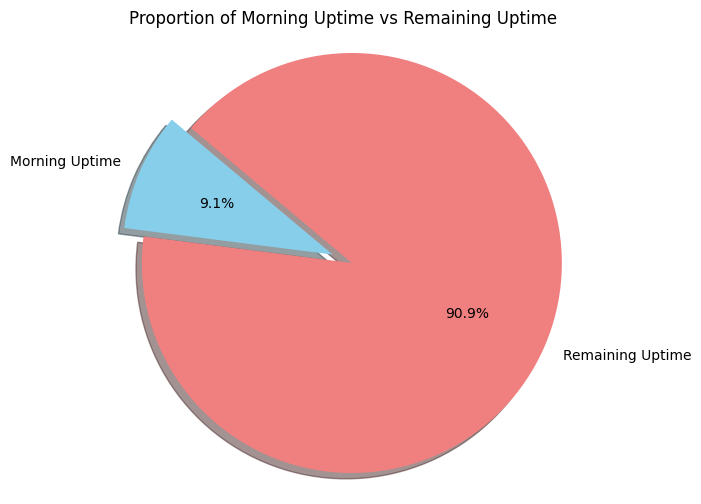

In [25]:
import matplotlib.pyplot as plt

# Calculating the proportion of morning uptime
morning_proportion = total_cars_uptime / len(up_speed1)

# Calculating the proportion of total uptime excluding morning uptime
remaining_proportion = 1 - morning_proportion

# Pie chart data
labels = ['Morning Uptime', 'Remaining Uptime']
sizes = [morning_proportion, remaining_proportion]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # Explode the morning uptime slice for emphasis

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding title
plt.title('Proportion of Morning Uptime vs Remaining Uptime')

# Show plot
plt.show()


#  detecting objects and drawing 2 lines on image - red and blue

In [62]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')


while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy() 
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
                 
    

    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()


0: 320x640 9 cars, 3 trucks, 327.8ms
Speed: 4.0ms preprocess, 327.8ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 305.4ms
Speed: 4.0ms preprocess, 305.4ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 293.7ms
Speed: 3.0ms preprocess, 293.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 255.3ms
Speed: 3.2ms preprocess, 255.3ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 235.7ms
Speed: 2.0ms preprocess, 235.7ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


KeyboardInterrupt: 

# getting the ids of the cars those are touching red line

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time
from datetime import datetime

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')

down={}
up={}

counter_down=[]
counter_up=[]

while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy()  # added this line
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        # cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        # cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        # cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
           
        ''' condition for red line '''
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
          ''' this if condition is putting the id and the circle on the object when the center of the object touched the red line.'''
          
          down[id]=time.time()  # current time when vehicle touch the red line

          # a = time.time()  
          # dt_object = datetime.fromtimestamp(a)
          # # Format the datetime object as a string in a readable format
          # formatted_time = dt_object.strftime("%Y-%m-%d %H:%M:%S")
          # print("Readable time:", formatted_time)
            
          #This will tell us the travelling direction of the car.
          if id in down:         
           cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
           cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box             
           cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
    
    # print("Readable time:", formatted_time)
    print(down)  # printing the id and time of the vehicle when it is touching the red line
    

    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# getting the ids of the cars those are touching red line¶

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')

down={}
up={}

counter_down=[]
counter_up=[]

while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy()  # added this line
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        # cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        # cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        # cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
           
    #     ''' condition for red line '''
    #     if red_line_y < (cy + offset) and red_line_y > (cy - offset):
    #       ''' this if condition is putting the id and the circle on the object when the center of the object touched the red line.'''
          
    #       down[id]=time.time()  # current time when vehicle touch the red line
    #       #This will tell us the travelling direction of the car.
    #       if id in down:         
    #        cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
    #        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box             
    #        cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

    #print(down)  # printing the id and time of the vehicle when it is touching the red line
    

        ''' condition for blue line '''

        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
          up[id]=time.time()   ## current time when vehicle touch the blue line
          if id in up:         
           cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
           cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)        
           counter_up.append(id)        

    print(up)  # printing the id and time of the vehicle when it is touching the red line

    
    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

# entire code

##### how to calculate speed?

We will use the speed formula which is 
#### speed= distance/time  (distance travelled and elapsed time) 
Elapsed time is the duration between the starting point and the ending point of the movement.

distance = 10 # meters :- distance between the 2 lines(red and blue line) is 10 meters
a_speed_ms = distance / elapsed_time   # ms is meter per second.
We can apply this formula because we have distance and elapsed time.

a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside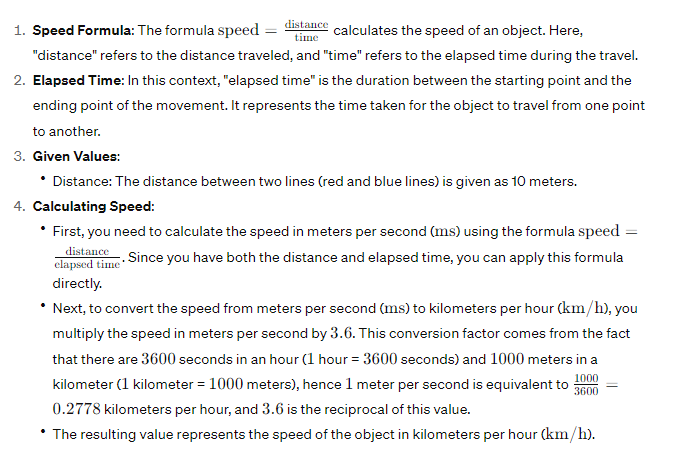

In [ ]:
import cv2
import os
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker

model = YOLO('yolov8s.pt')

cap = cv2.VideoCapture('highway.mp4')
#cap = cv2.VideoCapture('highway_mini.mp4')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

count = 0
tracker = Tracker()
down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        # if red_line_y < (cy + offset) and red_line_y > (cy - offset):
        #     down[id] = cy
        # if id in down:
        #     if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
        #         cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
        #         cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
        #         counter_down.add(id)  # Add ID to set

        # if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
        #     up[id] = cy
        # if id in up:
        #     if red_line_y < (cy + offset) and red_line_y > (cy - offset):
        #         cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
        #         cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
        #         counter_up.add(id)  # Add ID to set


        if red_line_y<(cy+offset) and red_line_y > (cy-offset):
           down[id]=time.time()   # current time when vehichle touch the first line
        if id in down:
          
           if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
             elapsed_time=time.time() - down[id]  # current time when vehicle touch the second line. Also we a re minusing the previous time ( current time of line 1)
             if counter_down.count(id)==0:
                counter_down.append(id)
                distance = 10 # meters - distance between the 2 lines is 10 meters
                a_speed_ms = distance / elapsed_time
                a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh))+'Km/h',(x4,y4 ),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

                
        #####going UP#####     
        if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
           up[id]=time.time()
        if id in up:

           if red_line_y<(cy+offset) and red_line_y > (cy-offset):
             elapsed1_time=time.time() - up[id]
             # formula of speed= distance/time  (distance travelled and elapsed time) Elapsed time is It represents the duration between the starting point and the ending point of the movement.
             if counter_up.count(id)==0:
                counter_up.append(id)      
                distance1 = 10 # meters  (Distance between the 2 lines is 10 meters )
                a_speed_ms1 = distance1 / elapsed1_time
                a_speed_kh1 = a_speed_ms1 * 3.6
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh1))+'Km/h',(x4,y4),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)



    
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
    #if cv2.waitKey(0) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


NameError: name '_C' is not defined